## Adversarial attacks - comparison across multiple models
This notebook compares the effectiveness of several adversarial attacks (FGSM, PGD, CW, DeepFool) against multiple pre-trained models (ResNet50, VGG16, DenseNet121, MobileNetV2) on a subset of ImageNet data.

In [1]:
import torch
import torch.utils.data as data
import torchvision.models as models
import torchvision.datasets as datasets

from attacks.fgsm import FGSM
from attacks.pgd import PGD
from attacks.cw import CW
from attacks.deepfool import DeepFool

from utils.helpers import preprocess, set_seed, load_imagenet_classes
from utils.evaluation import evaluate_all_attacks, print_accuracy_confidence
from utils.visualization import visualize_adversarial_grid, plot_model_comparison_bar_chart

## Configuration

In [2]:
IMAGENET_VAL_DIR = './data/imagenet_val/'
LABEL_MAP_FILE = './data/imagenet_classes.txt'
BATCH_SIZE = 32 # How many images to process at once
NUM_IMAGES = 512 # How many images to process in total
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 806

# Set random seed for reproducibility
set_seed(SEED, DEVICE)

# Check device
print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
if NUM_IMAGES > 1000:
    raise ValueError("NUM_IMAGES must be less than or equal to 1000, the number of images in the dataset.")

### Load ImageNet Data and Class Labels

In [3]:
# Create a dataset object
imagenet_data = datasets.ImageFolder(IMAGENET_VAL_DIR, transform=preprocess)
print(f"Found {len(imagenet_data)} images in {IMAGENET_VAL_DIR}")

# Use a subset of the data
subset_indices = list(range(min(NUM_IMAGES, len(imagenet_data))))
imagenet_subset = data.Subset(imagenet_data, subset_indices)

# Create a DataLoader
test_loader = data.DataLoader(imagenet_subset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Created DataLoader with {len(imagenet_subset)} images.")

# Load class labels
imagenet_classes = load_imagenet_classes(LABEL_MAP_FILE)
print(f"Loaded {len(imagenet_classes)} class names from index file.")

Found 1000 images in ./data/imagenet_val/
Created DataLoader with 512 images.
Loaded 1000 class names from index file.


### Define Models to Test
We will test ResNet50, VGG16, DenseNet121, and MobileNetV2.

In [4]:
model_archs = {
    "ResNet50": models.resnet50,
    "VGG16": models.vgg16,
    "DenseNet121": models.densenet121,
    "MobileNetV2": models.mobilenet_v2
}

model_weights = {
    "ResNet50": models.ResNet50_Weights.IMAGENET1K_V2,
    "VGG16": models.VGG16_Weights.IMAGENET1K_V1,
    "DenseNet121": models.DenseNet121_Weights.IMAGENET1K_V1,
    "MobileNetV2": models.MobileNet_V2_Weights.IMAGENET1K_V2
}

# Store all results here
all_model_results = {}

Load models

In [5]:
loaded_models = {}

for model_name, model_loader in model_archs.items():
    print(f"Loading {model_name}...")
    model = model_loader(weights=model_weights[model_name])
    model = model.to(DEVICE)
    model.eval()
    loaded_models[model_name] = model
    print(f"{model_name} loaded successfully.")

print("\n--- All Models Loaded ---")

Loading ResNet50...


ResNet50 loaded successfully.
Loading VGG16...


VGG16 loaded successfully.
Loading DenseNet121...


DenseNet121 loaded successfully.
Loading MobileNetV2...


MobileNetV2 loaded successfully.

--- All Models Loaded ---


### Define Fixed Attack Parameters

### Attack Parameter Selection Rationale
To ensure a fair comparison between adversarial attack methods, the following parameters are chosen so that all attacks are of comparable strength and intent:
- FGSM and PGD use the same epsilon (perturbation budget), as both are L-infinity norm attacks. PGD uses more steps to be a stronger iterative attack, but with the same epsilon as FGSM.
- CW and DeepFool are optimization-based and L2 attacks; their steps and confidence are set to moderate values so they are not excessively strong compared to FGSM/PGD.
- All attacks are configured to produce visually imperceptible perturbations.

In [6]:
# FGSM
FGSM_EPSILON = 0.03

# PGD
PGD_EPSILON = 0.03
PGD_ALPHA = 0.007
PGD_STEPS = 10

# CW
CW_C = 1
CW_KAPPA = 0
CW_STEPS = 100
CW_LR = 0.01

# DeepFool
DF_STEPS = 5
DF_OVERSHOOT = 0.02
NUM_CLASSES = 1000

## Run Attacks on Each Model

In [7]:
for model_name, current_model in loaded_models.items():
    print(f"\n--- Evaluating Model: {model_name} ---")

    # Initialize attacks for the current model
    attacks_for_current_model = {
        'FGSM': FGSM(current_model, eps=FGSM_EPSILON),
        'PGD': PGD(current_model, eps=PGD_EPSILON, alpha=PGD_ALPHA, steps=PGD_STEPS),
        'CW': CW(current_model, c=CW_C, kappa=CW_KAPPA, steps=CW_STEPS, lr=CW_LR),
        'DeepFool': DeepFool(current_model, steps=DF_STEPS, overshoot=DF_OVERSHOOT, num_classes=NUM_CLASSES)
    }
    
    print(f"\nRunning attacks on {model_name}...")
    # Evaluate all attacks on the current model
    model_specific_results = evaluate_all_attacks(
        attacks_for_current_model,
        test_loader,
        current_model,
        DEVICE,
        NUM_IMAGES,
        imagenet_classes
    )
    
    all_model_results[model_name] = model_specific_results
    
    print(f"\nResults for {model_name}:")
    print_accuracy_confidence(model_specific_results, attacks_for_current_model)
    print("---------------------------------------\n")

print("\n--- All Model Evaluations Complete ---")


--- Evaluating Model: ResNet50 ---

Running attacks on ResNet50...

Starting evaluation...


  Batch 1/16: Processing 32 images...


    FGSM finished. Accuracy: 19/32


    PGD finished. Accuracy: 6/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 14/32


  Batch 2/16: Processing 32 images...
    FGSM finished. Accuracy: 17/32


    PGD finished. Accuracy: 2/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 11/32


  Batch 3/16: Processing 32 images...
    FGSM finished. Accuracy: 23/32


    PGD finished. Accuracy: 4/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 11/32


  Batch 4/16: Processing 32 images...
    FGSM finished. Accuracy: 20/32


    PGD finished. Accuracy: 7/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 5/32


  Batch 5/16: Processing 32 images...
    FGSM finished. Accuracy: 20/32


    PGD finished. Accuracy: 4/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 12/32


  Batch 6/16: Processing 32 images...
    FGSM finished. Accuracy: 10/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 4/32


  Batch 7/16: Processing 32 images...
    FGSM finished. Accuracy: 12/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 2/32


  Batch 8/16: Processing 32 images...
    FGSM finished. Accuracy: 10/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 8/32


  Batch 9/16: Processing 32 images...
    FGSM finished. Accuracy: 14/32


    PGD finished. Accuracy: 3/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 12/32


  Batch 10/16: Processing 32 images...
    FGSM finished. Accuracy: 15/32


    PGD finished. Accuracy: 2/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 4/32


  Batch 11/16: Processing 32 images...
    FGSM finished. Accuracy: 19/32


    PGD finished. Accuracy: 5/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 10/32


  Batch 12/16: Processing 32 images...
    FGSM finished. Accuracy: 20/32


    PGD finished. Accuracy: 1/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 8/32


  Batch 13/16: Processing 32 images...
    FGSM finished. Accuracy: 9/32


    PGD finished. Accuracy: 1/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 11/32


  Batch 14/16: Processing 32 images...
    FGSM finished. Accuracy: 13/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 7/32


  Batch 15/16: Processing 32 images...
    FGSM finished. Accuracy: 17/32


    PGD finished. Accuracy: 1/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 12/32


  Batch 16/16: Processing 32 images...
    FGSM finished. Accuracy: 13/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 11/32

Reached target number of images (512). Stopping.

Evaluation finished.

Results for ResNet50:
------------------------------
Accuracy and Average Confidence Results:
------------------------------
Clean Accuracy: 429/512 (83.79%)
Clean Avg Confidence: 0.4071
------------------------------
FGSM Accuracy: 251/512 (49.02%)
FGSM Avg Confidence: 0.1816
------------------------------
PGD Accuracy: 36/512 (7.03%)
PGD Avg Confidence: 0.4769
------------------------------
CW Accuracy: 0/512 (0.00%)
CW Avg Confidence: 0.2808
------------------------------
DeepFool Accuracy: 142/512 (27.73%)
DeepFool Avg Confidence: 0.1714
------------------------------
---------------------------------------


--- Evaluating Model: VGG16 ---

Running attacks on VGG16...

Starting evaluation...


  Batch 1/16: Processing 32 images...
    FGSM finished. Accuracy: 2/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 5/32


  Batch 2/16: Processing 32 images...
    FGSM finished. Accuracy: 2/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 5/32


  Batch 3/16: Processing 32 images...
    FGSM finished. Accuracy: 1/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 1/32


  Batch 4/16: Processing 32 images...
    FGSM finished. Accuracy: 6/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 4/32


  Batch 5/16: Processing 32 images...
    FGSM finished. Accuracy: 1/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 3/32


  Batch 6/16: Processing 32 images...
    FGSM finished. Accuracy: 0/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 2/32


  Batch 7/16: Processing 32 images...
    FGSM finished. Accuracy: 0/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 1/32


  Batch 8/16: Processing 32 images...
    FGSM finished. Accuracy: 1/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 6/32


  Batch 9/16: Processing 32 images...
    FGSM finished. Accuracy: 0/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 3/32


  Batch 10/16: Processing 32 images...
    FGSM finished. Accuracy: 1/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 3/32


  Batch 11/16: Processing 32 images...
    FGSM finished. Accuracy: 0/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 2/32


  Batch 12/16: Processing 32 images...
    FGSM finished. Accuracy: 0/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 1/32


  Batch 13/16: Processing 32 images...
    FGSM finished. Accuracy: 0/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 4/32


  Batch 14/16: Processing 32 images...
    FGSM finished. Accuracy: 1/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 4/32


  Batch 15/16: Processing 32 images...
    FGSM finished. Accuracy: 0/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 7/32


  Batch 16/16: Processing 32 images...
    FGSM finished. Accuracy: 0/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 7/32

Reached target number of images (512). Stopping.

Evaluation finished.

Results for VGG16:
------------------------------
Accuracy and Average Confidence Results:
------------------------------
Clean Accuracy: 377/512 (73.63%)
Clean Avg Confidence: 0.7640
------------------------------
FGSM Accuracy: 15/512 (2.93%)
FGSM Avg Confidence: 0.5865
------------------------------
PGD Accuracy: 0/512 (0.00%)
PGD Avg Confidence: 0.9752
------------------------------
CW Accuracy: 0/512 (0.00%)
CW Avg Confidence: 0.5255
------------------------------
DeepFool Accuracy: 58/512 (11.33%)
DeepFool Avg Confidence: 0.3473
------------------------------
---------------------------------------


--- Evaluating Model: DenseNet121 ---

Running attacks on DenseNet121...

Starting evaluation...


  Batch 1/16: Processing 32 images...


    FGSM finished. Accuracy: 3/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 7/32


  Batch 2/16: Processing 32 images...
    FGSM finished. Accuracy: 2/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 5/32


  Batch 3/16: Processing 32 images...
    FGSM finished. Accuracy: 2/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 2/32


  Batch 4/16: Processing 32 images...
    FGSM finished. Accuracy: 1/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 7/32


  Batch 5/16: Processing 32 images...
    FGSM finished. Accuracy: 4/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 7/32


  Batch 6/16: Processing 32 images...
    FGSM finished. Accuracy: 1/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 4/32


  Batch 7/16: Processing 32 images...
    FGSM finished. Accuracy: 0/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 1/32


  Batch 8/16: Processing 32 images...
    FGSM finished. Accuracy: 2/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 9/32


  Batch 9/16: Processing 32 images...
    FGSM finished. Accuracy: 1/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 4/32


  Batch 10/16: Processing 32 images...
    FGSM finished. Accuracy: 0/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 4/32


  Batch 11/16: Processing 32 images...
    FGSM finished. Accuracy: 1/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 4/32


  Batch 12/16: Processing 32 images...
    FGSM finished. Accuracy: 0/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 0/32


  Batch 13/16: Processing 32 images...
    FGSM finished. Accuracy: 0/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 3/32


  Batch 14/16: Processing 32 images...
    FGSM finished. Accuracy: 1/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 10/32


  Batch 15/16: Processing 32 images...
    FGSM finished. Accuracy: 0/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 5/32


  Batch 16/16: Processing 32 images...
    FGSM finished. Accuracy: 0/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 6/32

Reached target number of images (512). Stopping.

Evaluation finished.

Results for DenseNet121:
------------------------------
Accuracy and Average Confidence Results:
------------------------------
Clean Accuracy: 394/512 (76.95%)
Clean Avg Confidence: 0.8009
------------------------------
FGSM Accuracy: 18/512 (3.52%)
FGSM Avg Confidence: 0.6512
------------------------------
PGD Accuracy: 0/512 (0.00%)
PGD Avg Confidence: 0.9762
------------------------------
CW Accuracy: 0/512 (0.00%)
CW Avg Confidence: 0.5959
------------------------------
DeepFool Accuracy: 78/512 (15.23%)
DeepFool Avg Confidence: 0.3963
------------------------------
---------------------------------------


--- Evaluating Model: MobileNetV2 ---

Running attacks on MobileNetV2...

Starting evaluation...


  Batch 1/16: Processing 32 images...
    FGSM finished. Accuracy: 9/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 6/32


  Batch 2/16: Processing 32 images...
    FGSM finished. Accuracy: 1/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 7/32


  Batch 3/16: Processing 32 images...
    FGSM finished. Accuracy: 6/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 4/32


  Batch 4/16: Processing 32 images...
    FGSM finished. Accuracy: 7/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 5/32


  Batch 5/16: Processing 32 images...
    FGSM finished. Accuracy: 5/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 3/32


  Batch 6/16: Processing 32 images...
    FGSM finished. Accuracy: 0/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 1/32


  Batch 7/16: Processing 32 images...
    FGSM finished. Accuracy: 1/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 4/32


  Batch 8/16: Processing 32 images...
    FGSM finished. Accuracy: 3/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 6/32


  Batch 9/16: Processing 32 images...
    FGSM finished. Accuracy: 3/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 3/32


  Batch 10/16: Processing 32 images...
    FGSM finished. Accuracy: 4/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 5/32


  Batch 11/16: Processing 32 images...
    FGSM finished. Accuracy: 5/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 2/32


  Batch 12/16: Processing 32 images...
    FGSM finished. Accuracy: 6/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 4/32


  Batch 13/16: Processing 32 images...
    FGSM finished. Accuracy: 2/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 4/32


  Batch 14/16: Processing 32 images...
    FGSM finished. Accuracy: 6/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 3/32


  Batch 15/16: Processing 32 images...
    FGSM finished. Accuracy: 5/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 4/32


  Batch 16/16: Processing 32 images...
    FGSM finished. Accuracy: 4/32


    PGD finished. Accuracy: 0/32


    CW finished. Accuracy: 0/32


    DeepFool finished. Accuracy: 4/32

Reached target number of images (512). Stopping.

Evaluation finished.

Results for MobileNetV2:
------------------------------
Accuracy and Average Confidence Results:
------------------------------
Clean Accuracy: 387/512 (75.59%)
Clean Avg Confidence: 0.3707
------------------------------
FGSM Accuracy: 67/512 (13.09%)
FGSM Avg Confidence: 0.0798
------------------------------
PGD Accuracy: 0/512 (0.00%)
PGD Avg Confidence: 0.6835
------------------------------
CW Accuracy: 0/512 (0.00%)
CW Avg Confidence: 0.2158
------------------------------
DeepFool Accuracy: 65/512 (12.70%)
DeepFool Avg Confidence: 0.1287
------------------------------
---------------------------------------


--- All Model Evaluations Complete ---


## Overall Comparison of Models

In [8]:
attack_names = ['FGSM', 'PGD', 'CW', 'DeepFool']

print("\n--- Accuracy Comparison Across Models ---")
for model_name, results in all_model_results.items():
    clean_accuracy = (results['clean']['correct'] / results['clean']['total']) * 100
    print(f"\nModel: {model_name}")
    print(f"  Clean Accuracy: {clean_accuracy:.2f}%")

    for attack_name in attack_names:
        if attack_name in results:
            # Assuming accuracy from evaluate_all_attacks is 0-100.
            attack_accuracy = (results[attack_name]['correct'] / results[attack_name]['total']) * 100
            print(f"  {attack_name} Accuracy: {attack_accuracy:.2f}%")
        else:
            print(f"  {attack_name} Accuracy: Not available or attack failed")


--- Accuracy Comparison Across Models ---

Model: ResNet50
  Clean Accuracy: 83.79%
  FGSM Accuracy: 49.02%
  PGD Accuracy: 7.03%
  CW Accuracy: 0.00%
  DeepFool Accuracy: 27.73%

Model: VGG16
  Clean Accuracy: 73.63%
  FGSM Accuracy: 2.93%
  PGD Accuracy: 0.00%
  CW Accuracy: 0.00%
  DeepFool Accuracy: 11.33%

Model: DenseNet121
  Clean Accuracy: 76.95%
  FGSM Accuracy: 3.52%
  PGD Accuracy: 0.00%
  CW Accuracy: 0.00%
  DeepFool Accuracy: 15.23%

Model: MobileNetV2
  Clean Accuracy: 75.59%
  FGSM Accuracy: 13.09%
  PGD Accuracy: 0.00%
  CW Accuracy: 0.00%
  DeepFool Accuracy: 12.70%


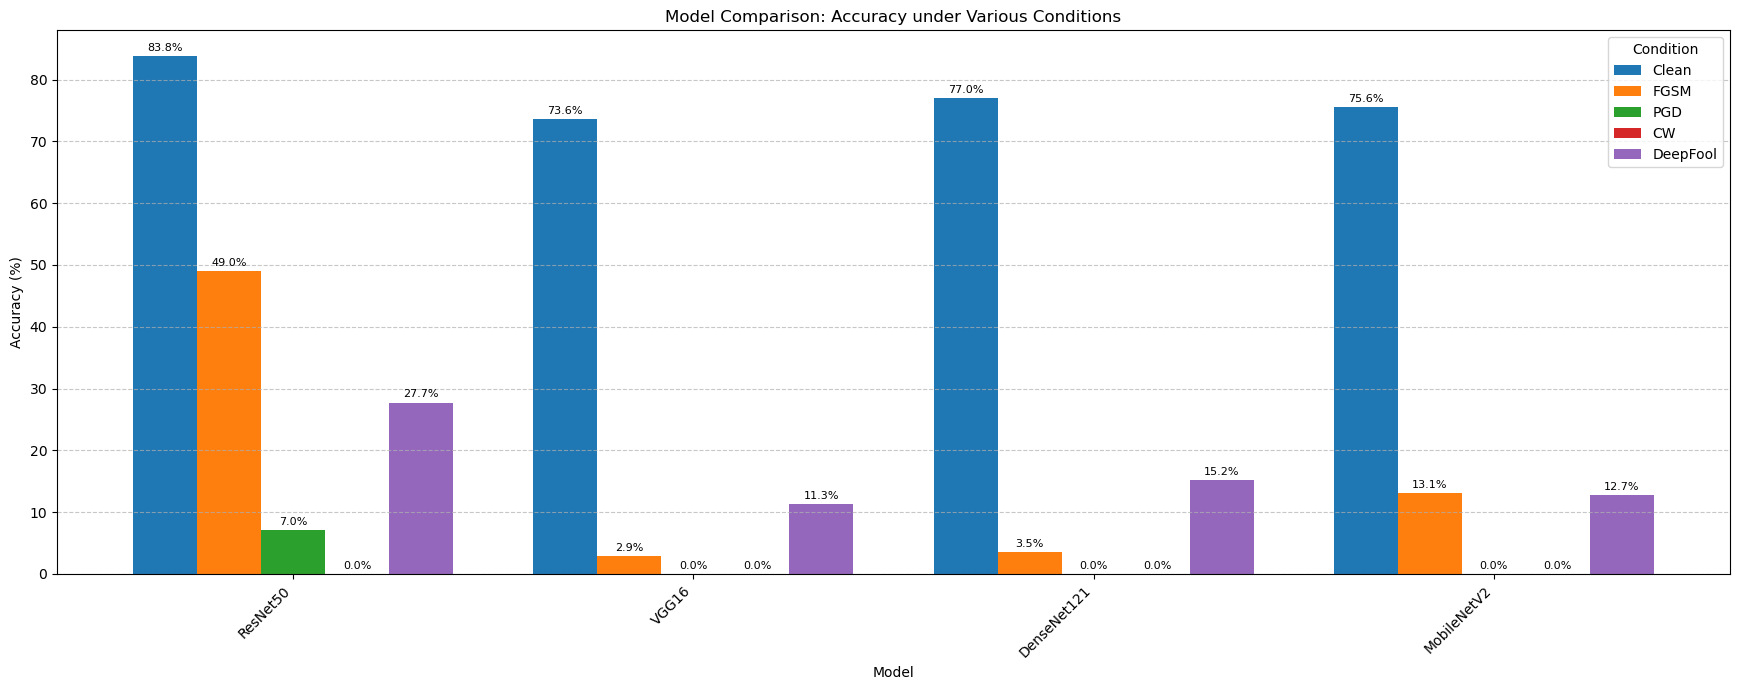

In [9]:
# Plotting the comparison
plot_model_comparison_bar_chart(all_model_results, attack_names, metric='accuracy')

## Visualize Adversarial Examples (for VGG16)

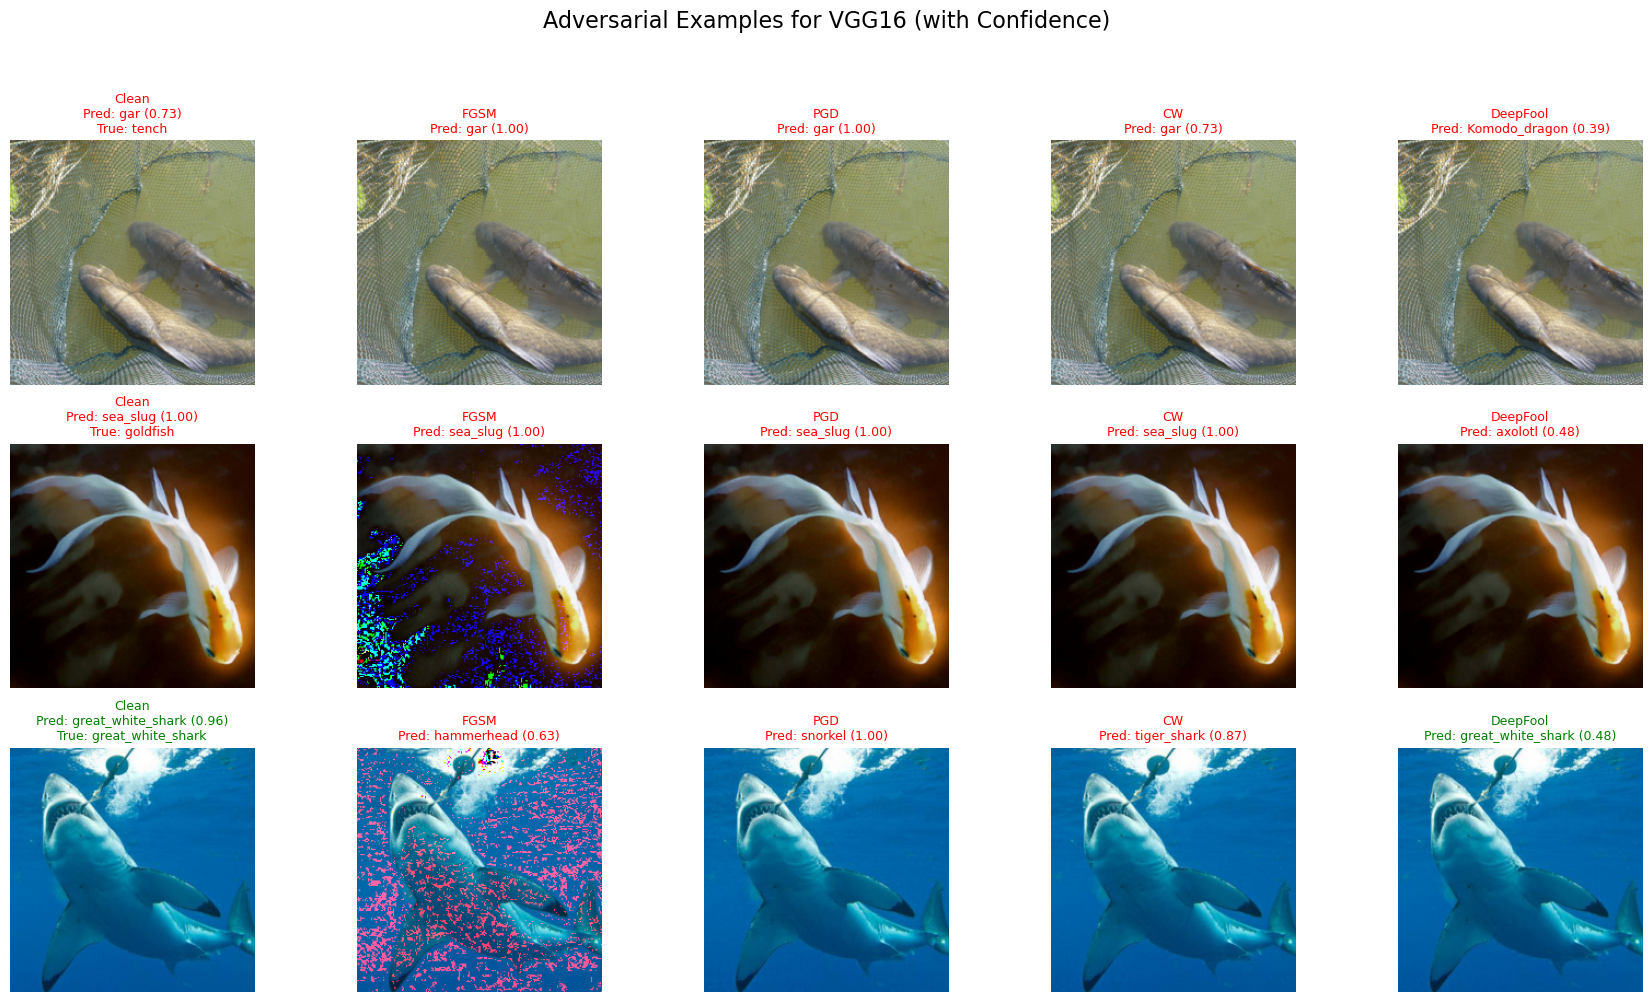

In [10]:
target_model_for_viz = "VGG16"

results_for_viz = all_model_results[target_model_for_viz]
num_samples_to_show = min(3, results_for_viz['clean']['total'] if 'clean' in results_for_viz and results_for_viz['clean']['total'] > 0 else 0)

comparison_column_defs = [
    {'title_segment': attack_name, 'data_results': results_for_viz[attack_name]} 
    for attack_name in attack_names if attack_name in results_for_viz
]

visualize_adversarial_grid(
    num_samples_to_show=num_samples_to_show, 
    clean_data=results_for_viz['clean'], 
    column_definitions=comparison_column_defs, 
    imagenet_classes=imagenet_classes, 
    figure_suptitle=f"Adversarial Examples for {target_model_for_viz} (with Confidence)"
)